In [11]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

### Instructions

Your case study is to build a classifier using logistic regression to predict hospital readmittance. 
There is missing data that must be imputed. Once again, discuss variable importances as part of your submission.

### Team:
- Dylan Scott
- Jobin Joseph
- Taylor Bonar
- Satvik Ajmera

In [12]:
#data
diabetes_df = pd.read_csv("../dataset_diabetes/diabetic_data.csv", header=0, na_values="?", low_memory=False)
diabetes_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [13]:
diabetes_df['race'].value_counts()

Caucasian          76099
AfricanAmerican    19210
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

In [14]:
diabetes_df['age'].value_counts()

[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64

In [15]:
age_values = list(diabetes_df['age'].unique())

In [16]:
diabetes_df['gender'].value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

In [17]:
#value dictionaries
Race = {'Caucasian':0, 'AfricanAmerican':1, 'Hispanic':2,'Other':3,'Asian':4, np.nan:5}
Gender = {'Male': 1,'Female': 0,'Unknown/Invalid':3}
Age = {}
count = 0
for i in range(len(age_values)):
    Age[age_values[i]] = count
    count+=1

diabetes_df.race = [Race[item] for item in diabetes_df.race]
diabetes_df.gender = [Gender[item] for item in diabetes_df.gender]
diabetes_df.age = [Age[item] for item in diabetes_df.age]
diabetes_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,0,0,0,NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,0,0,1,NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,1,0,2,NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,0,1,3,NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,0,1,4,NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


<function matplotlib.pyplot.show(close=None, block=None)>

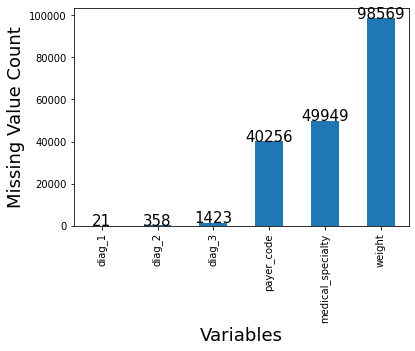

<Figure size 720x1800 with 0 Axes>

In [18]:

#iterate though all the columns and show all the possible vaules 
#next make sure to actually swap out the values
#but first lets look at missing values
missing = diabetes_df.isna().sum()
missing = pd.DataFrame(missing, columns = ['missing'])
missing = missing[(missing.T !=0).any()]
missing = missing.sort_values('missing')

missing.plot(kind = 'bar', legend = False)
plt.ylabel('Missing Value Count', fontsize=18)
plt.xlabel('Variables', fontsize=18)
plt.xticks(rotation='90')
for index,data in enumerate(missing['missing']):
    plt.text(x=index , y =data+2 , s=f"{data}" , fontdict=dict(fontsize=15), ha='center')
plt.figure(figsize=(10, 25))
plt.show

In [19]:
#per the profs recc we should drop wight since it is missing for more than half the dataset
#drop weight, payer code and medical spec
diabetes_df = diabetes_df.drop(columns=['weight','payer_code','medical_specialty'])

In [ ]:
#should we fill in the unknown race?
diabetes_df = diabetes_df['race'].fillna('Caucasian')

In [ ]:
#pd get dummies

#number cols

#categorical vars

